In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('D:\corona\DATA\Frozen_Dessert_Production.csv')
data

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636
...,...,...
568,2019-05-01,114.5613
569,2019-06-01,124.9605
570,2019-07-01,110.2632
571,2019-08-01,102.6085


In [3]:
df = pd.read_csv('D:\corona\DATA\Frozen_Dessert_Production.csv',parse_dates=True,index_col='DATE')
df

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
IPN31152N    573 non-null float64
dtypes: float64(1)
memory usage: 9.0 KB


In [9]:
df.columns=['Production']

In [10]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


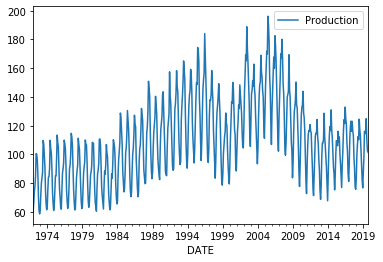

In [11]:
df.plot()

In [12]:
len(df)

573

In [13]:
len(df)-24

549

In [14]:
test_size = 24

test_index = len(df) - test_size

In [15]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)

scaler_train = scaler.transform(train)

scaler_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 18
n_feature = 1
generator = TimeseriesGenerator(scaler_train,scaler_train,length=length,batch_size=1)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(100,input_shape=(length,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
validation_generator = TimeseriesGenerator(scaler_test,scaler_test,length=length,batch_size=1)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [25]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
531/531 [==============================] - 19s 36ms/step - loss: 0.0194 - val_loss: 0.0023
Epoch 2/20
531/531 [==============================] - 19s 37ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 3/20
531/531 [==============================] - 20s 38ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 4/20
531/531 [==============================] - 20s 37ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 5/20
531/531 [==============================] - 20s 37ms/step - loss: 0.0032 - val_loss: 0.0019


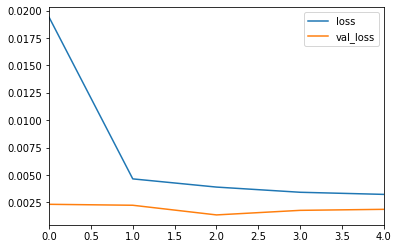

In [26]:
loss=pd.DataFrame(model.history.history)
loss.plot()

In [29]:
test_predictions = []

first_eval_batch = scaler_train[-length:] 
curr_batch = first_eval_batch.reshape((1,length,n_feature))

for i in range(len(test)):
    
    curr_pred = model.predict(curr_batch)[0]
    
    test_predictions.append(curr_pred)
    
    curr_batch=np.append(curr_batch[:,1:,:],[[curr_pred]],axis=1)

In [30]:
true_pred = scaler.inverse_transform(test_predictions)

In [31]:
test['Predictions'] = true_pred

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,90.967524
2017-11-01,77.4378,86.722461
2017-12-01,75.8118,87.518958
2018-01-01,83.4343,93.773158
2018-02-01,99.4899,101.764033
2018-03-01,107.3152,109.849246
2018-04-01,112.4309,115.947823
2018-05-01,110.3544,119.335275
2018-06-01,124.5841,118.264739


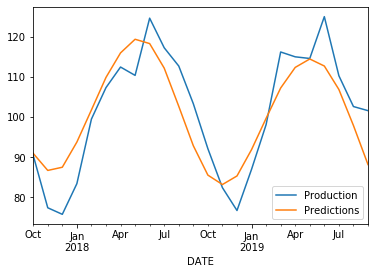

In [33]:
test.plot()

In [35]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

7.375175036204218